In [73]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# path to store data and/or load from
!mkdir -p datasets
data_path="./datasets"

In [113]:
transform = transforms.Compose(
                                [
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]
                              )

train_data = datasets.CIFAR10(root=data_path, train=True, 
                              transform=transform, download=True)
x_train, y_train = train_data.data,train_data.targets

val_data = datasets.CIFAR10(root=data_path, train=False, 
                            transform=transform, download=True)
x_val,y_val = val_data.data, val_data.targets

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [122]:
# define hyper parameters
num_classes   = len( set(train_data.targets) )
num_epochs    = 10
batch_size    = 4
learning_rate = 0.001

In [116]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size,
                                         shuffle=False)

In [117]:
examples = iter(train_loader)
samples, labels = examples.next()

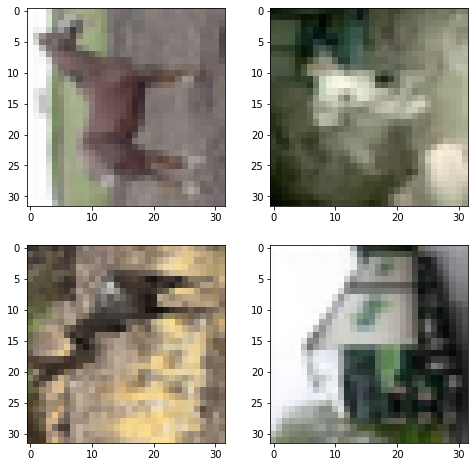

In [118]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    img = (samples[i] + 1) / 2
    img = img.T
    plt.imshow(img)
plt.show()

In [119]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        # Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5))
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5))
        self.pool  = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d( 6, 16, kernel_size=(5,5))
        self.fc1   = nn.Linear(16*5*5, 120) # 16 input tensors are 5x5
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84 , num_classes)

    def forward(self, x):
        x = F.relu( self.conv1(x) )
        x = self.pool(x)
        x = F.relu( self.conv2(x) )
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [123]:
model = ConvNet(num_classes).to(device)
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [2000/12500], Loss: 2.2921
Epoch [1/10], Step [4000/12500], Loss: 2.3168
Epoch [1/10], Step [6000/12500], Loss: 2.2968
Epoch [1/10], Step [8000/12500], Loss: 2.2779
Epoch [1/10], Step [10000/12500], Loss: 2.1905
Epoch [1/10], Step [12000/12500], Loss: 2.1512
Epoch [2/10], Step [2000/12500], Loss: 1.5954
Epoch [2/10], Step [4000/12500], Loss: 1.5765
Epoch [2/10], Step [6000/12500], Loss: 1.8405
Epoch [2/10], Step [8000/12500], Loss: 1.8938
Epoch [2/10], Step [10000/12500], Loss: 1.5023
Epoch [2/10], Step [12000/12500], Loss: 1.1121
Epoch [3/10], Step [2000/12500], Loss: 1.5604
Epoch [3/10], Step [4000/12500], Loss: 1.2879
Epoch [3/10], Step [6000/12500], Loss: 1.2568
Epoch [3/10], Step [8000/12500], Loss: 3.0857
Epoch [3/10], Step [10000/12500], Loss: 1.6097
Epoch [3/10], Step [12000/12500], Loss: 1.7242
Epoch [4/10], Step [2000/12500], Loss: 1.4251
Epoch [4/10], Step [4000/12500], Loss: 1.4069
Epoch [4/10], Step [6000/12500], Loss: 2.1690
Epoch [4/10], Step [8000/125

In [124]:
# test iteration
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0] * 10
    n_class_samples = [0] * 10
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # calculate predictions
        outputs = model(images)
        pred_val1, pred_idx1 = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (pred_idx1 == labels).sum()

        for i in range(batch_size):
            label = labels[i]
            pred = pred_idx1[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    print(f'acc: {100 * n_correct/n_samples}')
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

acc: 56.560001373291016
Accuracy of the network: 56.560001373291016 %
Accuracy of plane: 59.8 %
Accuracy of car: 71.7 %
Accuracy of bird: 44.7 %
Accuracy of cat: 33.9 %
Accuracy of deer: 43.1 %
Accuracy of dog: 40.9 %
Accuracy of frog: 81.0 %
Accuracy of horse: 53.8 %
Accuracy of ship: 73.5 %
Accuracy of truck: 63.2 %
